In [37]:
# https://github.com/cda-tum/qcec
!pip install mqt.qcec==2.0.0rc1
!pip install qiskit
!pip install mqt.ddsim 

In [38]:
from qiskit import *
from qiskit.test.mock import FakeAthens
from mqt import qcec
from qiskit.circuit.library import PhaseOracle

In [39]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = PhaseOracle.from_dimacs_file('examples.dimacs')
##oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

In [40]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [41]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

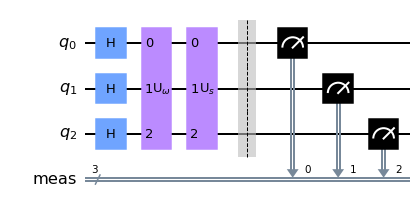

In [42]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

In [43]:
# compile circuit to 5 qubit London Architecture
circ_comp = transpile(grover_circuit, backend=FakeAthens())
print(circ_comp.draw(fold=-1))

Figure(3068.79x385.28)


In [44]:
circ_comp.data.pop(0)
print(circ_comp.draw(fold=-1))

Figure(3068.79x385.28)


In [45]:
job = execute(circ_comp, FakeAthens(), shots = 1000)
result = job.result()
counts = result.get_counts(circ_comp)
print(counts)

{'010': 59, '001': 57, '101': 217, '100': 249, '110': 79, '000': 60, '111': 217, '011': 62}


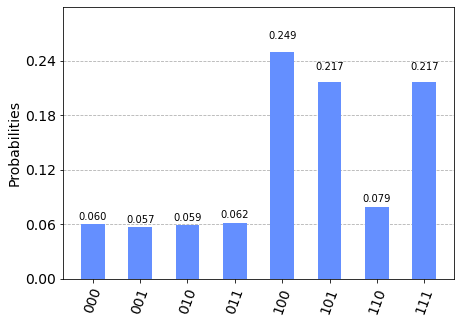

In [46]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)